In [17]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils import data as tdata
from torchvision import models as tmodels

import matplotlib.pyplot as plt
from IPython.display import clear_output

from importlib import reload

import preproc
import models.utils as mutils

In [276]:
data = pd.read_csv('data/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [277]:
reload(preproc)

<module 'preproc' from '/home/rena/egor_workspace/Kaggle_MNIST/preproc.py'>

In [278]:
data = preproc.end_to_end_preprocess(data)

In [279]:
train_data, test_data, val_data = tdata.random_split(data, (33600, 6300, 2100))

In [280]:
augm = tt.Compose([
    tt.Resize(size=(32, 32)),
    tt.RandomRotation(30, fill=(0,)),
    tt.RandomResizedCrop(size=32, scale=(.8, 1.2)),
    tt.ToTensor()
])

false_augm = tt.Compose([
    tt.Resize(size=(32, 32)),
    tt.ToTensor()
])

In [281]:
train_data = preproc.DatasetFromSubset(train_data, transform=augm)
test_data = preproc.DatasetFromSubset(test_data, transform=augm)
val_data = preproc.DatasetFromSubset(val_data, transform=false_augm)

Visualization of the augmentation:


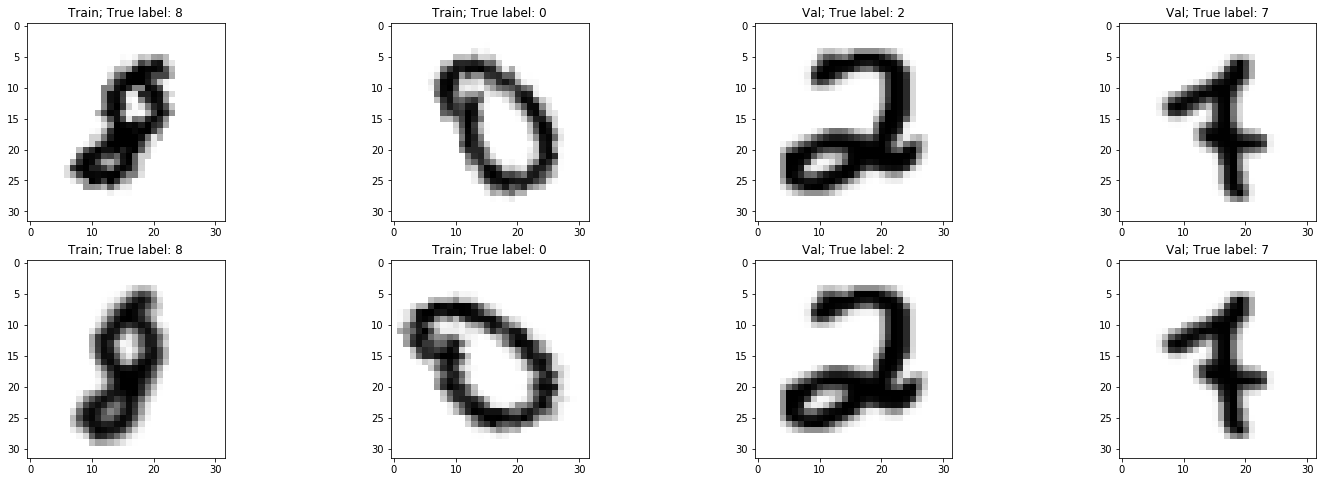

In [288]:
print('Visualization of the augmentation:')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 8))
for i, idx in enumerate(np.random.randint(0, len(train_data), (2))):
    for j in range(2):
        x, y = train_data[idx]
        axes[j, i].imshow(x[0], cmap='gray_r')
        axes[j, i].set_title('Train; True label: {}'.format(y))
    
for i, idx in enumerate(np.random.randint(0, len(val_data), (2))):
    for j in range(2):
        x, y = val_data[idx]
        axes[j, i+2].imshow(x[0], cmap='gray_r')
        axes[j, i+2].set_title('Val; True label: {}'.format(y))

In [289]:
batch_size = 1024

train_dataloader = tdata.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16)
test_dataloader = tdata.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=16)
val_dataloader = tdata.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=16)

dataloaders = {'train':train_dataloader, 'test':test_dataloader, 'val':val_dataloader}

In [322]:
model = tmodels.resnet18(num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.cuda();

In [323]:
ce_loss = nn.CrossEntropyLoss()
calculate_loss = lambda pred, true: ce_loss(pred, true)

In [328]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [325]:
epoch_i = 0

losses_dict = {'train':[], 'test':[]}

In [331]:
n_epochs = 25

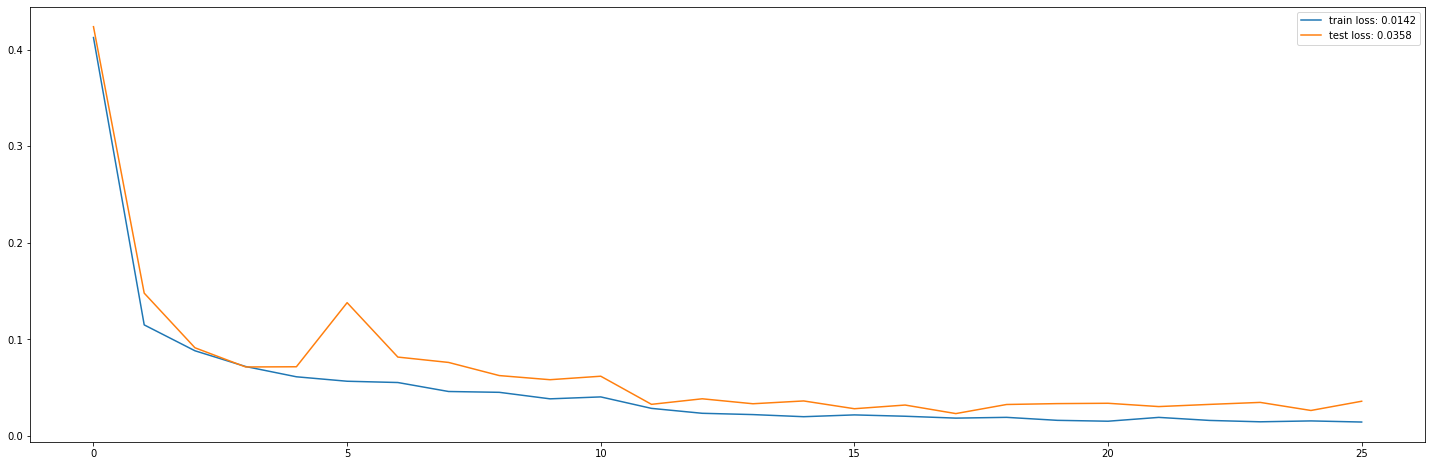

In [332]:
while epoch_i <= n_epochs:
    for mode in ['train', 'test']:
        
        if mode=='train':
            model.train()
        else:
            model.eval()
            
        losses = []
        for feats, target in dataloaders[mode]:
            feats, target = feats.cuda(), target.cuda()
            pred = model(feats)
            loss = calculate_loss(pred, target)

            losses.append(loss.item())
            
            if mode=='train':
                loss.backward()
                opt.step()
                opt.zero_grad()
                
        losses_dict[mode].append(np.mean(losses))
                
    epoch_i += 1
    
    if epoch_i % 1 == 0:
        clear_output(True)
        mutils.visualize_loss(losses_dict)

In [333]:
model.eval()

n_correct = 0
losses = []
for feats, target in dataloaders['val']:
    feats, target = feats.cuda(), target.cuda()
    pred = model(feats)
    loss = ce_loss(pred, target)
    losses.append(loss.item())
    
    pred = pred.softmax(1).argmax(1)
    correct = (pred == target).sum()
    n_correct += correct.item()
    
print('Validation:\n\tAccuracy: {:.4f};\tCross Entropy: {:.4f}'.format(n_correct / len(val_data), np.mean(losses)))

Validation:
	Accuracy: 0.9919;	Cross Entropy: 0.0211


In [379]:
submit_data = pd.read_csv('data/test.csv')
submit_data.insert(0, 'label', 0)
submit_data = preproc.end_to_end_preprocess(submit_data)
submit_data = preproc.DatasetFromSubset(submit_data, transform=false_augm)

In [385]:
submit_results = {'ImageId':[], 'Label':[]}
for i in range(len(submit_data)):
    feats, _ = submit_data[i]
    feats = feats.unsqueeze(1).cuda()
    pred = model(feats).softmax(1).argmax(1)
    submit_results['ImageId'].append(i+1)
    submit_results['Label'].append(pred.item())
    
    if i % 1000 == 0:
        clear_output()
        print('{}/{}'.format(i, len(submit_data)))

27000/28000


In [397]:
export = pd.DataFrame.from_dict(submit_results)
export.to_csv('submission.csv', index=False)